# Exploratory Data Analysis & Regression

Today we will be dealing with the medical costs dataset. This dataset contains information about people and their medical costs. We will be using this dataset to predict the medical costs of people based on their information.
Dataset contains following columns:
age, sex, bmi, children, smoker, regions and charges.

In [303]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import FeatureUnion
from sklearn.model_selection import cross_val_score

from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.svm import LinearSVR
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score

# Loading the dataset

In [176]:
def load_insurance_data():
    csv_path = "./datasets/insurance.csv"
    return pd.read_csv(csv_path)

In [177]:
insurance = load_insurance_data()

# Quick Look at the dataset

In [178]:
insurance.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [179]:
# quick description of the dataset
insurance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


Looking at the columns having "object" datatype to know which categorical value has how many data instances.

In [180]:
insurance["sex"].value_counts()

male      676
female    662
Name: sex, dtype: int64

In [181]:
insurance["smoker"].value_counts()

no     1064
yes     274
Name: smoker, dtype: int64

In [182]:
insurance["region"].value_counts()

southeast    364
southwest    325
northwest    325
northeast    324
Name: region, dtype: int64

In [183]:
# Summary of the numerical attributes of the dataset
insurance.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


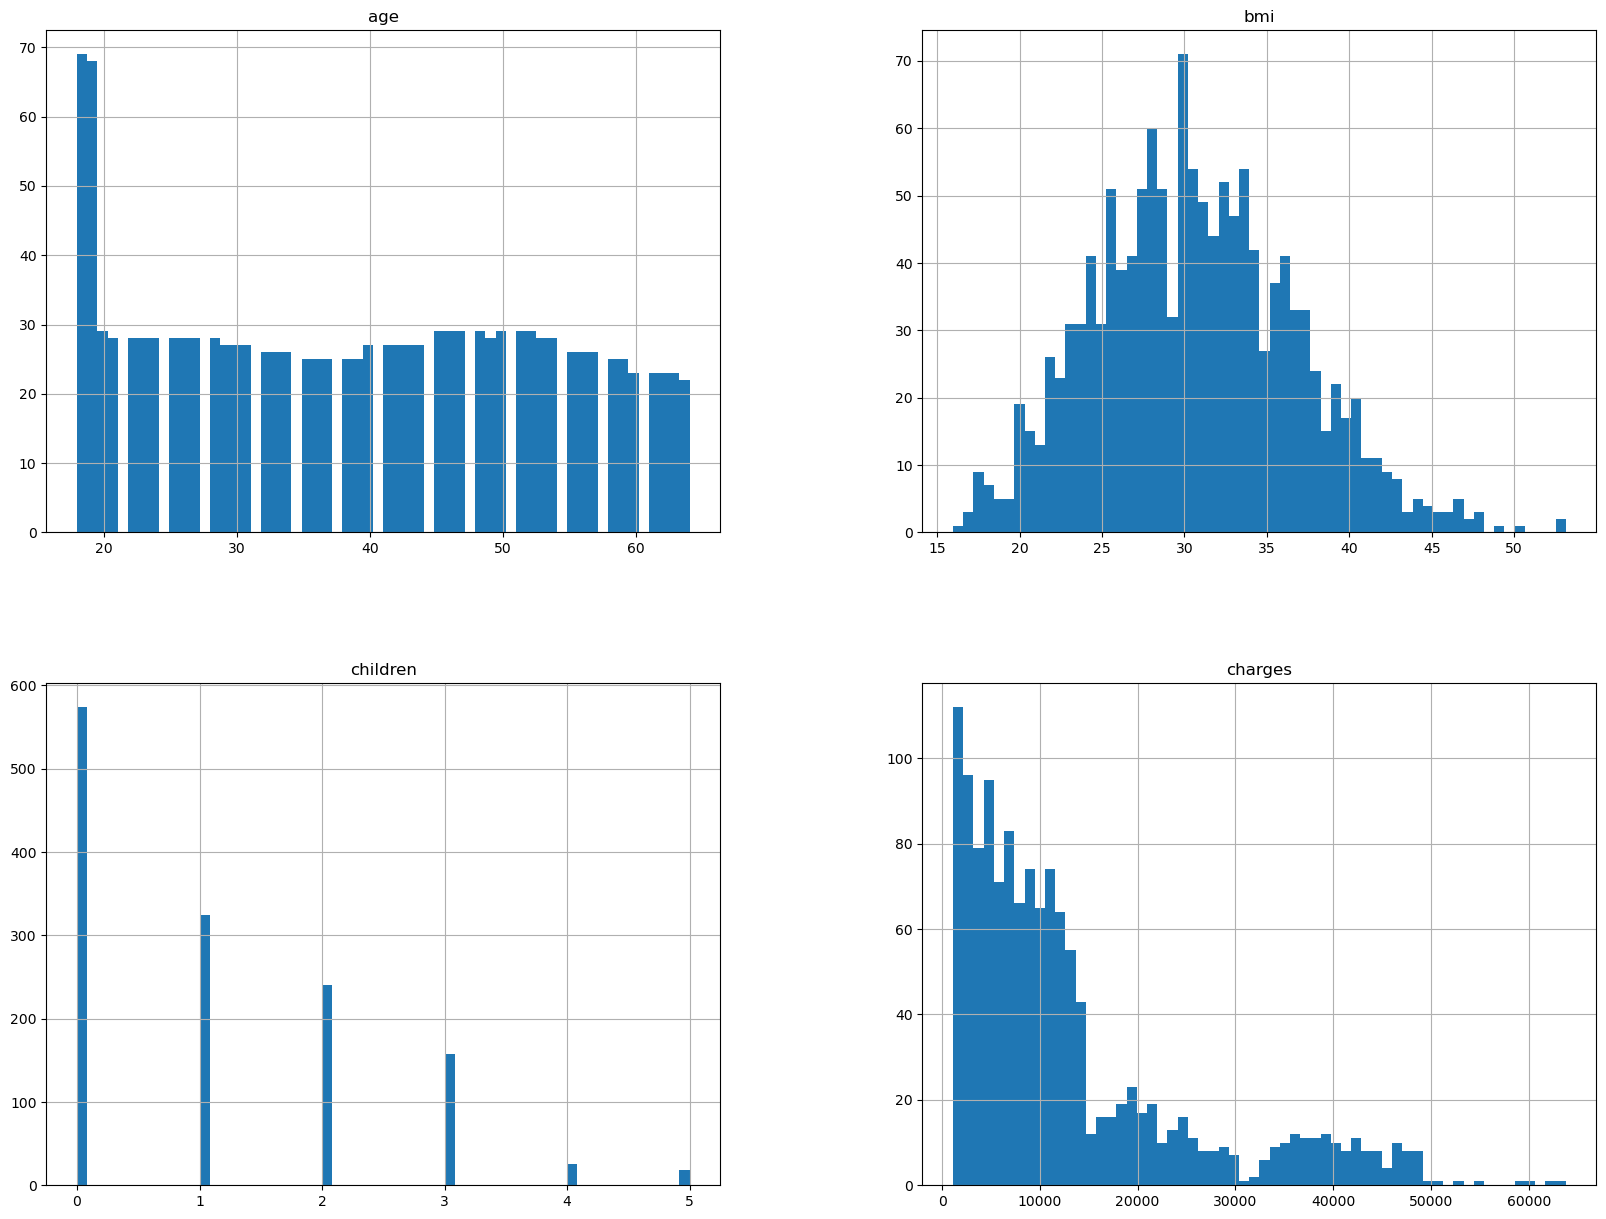

In [184]:
# Another quick way to get feel of the data we are dealing with is to plot a histogram for each numerical attribute.

insurance.hist(bins=60, figsize=(20, 15))
plt.show()

# Splitting data into Train and Test set

Before exploring the data further, let's first split the data into train set and test set. 

In [185]:
train_set, test_set = train_test_split(insurance, test_size=0.2, random_state=42)

In [186]:
train_set.head()

,age,sex,bmi,children,smoker,region,charges
560,46,female,19.95,2,no,northwest,9193.83850
1285,47,female,24.32,0,no,northeast,8534.67180
1142,52,female,24.86,0,no,southeast,27117.99378
969,39,female,34.32,5,no,southeast,8596.82780
486,54,female,21.47,3,no,northwest,12475.35130


# Visualizing the dataset to gain insights

Looking for correlations

In [187]:
corr_mat = train_set.corr(numeric_only=True)
corr_mat

,age,bmi,children,charges
age,1.000000,0.118274,0.060999,0.281721
bmi,0.118274,1.000000,-0.005040,0.197316
children,0.060999,-0.005040,1.000000,0.071885
charges,0.281721,0.197316,0.071885,1.000000


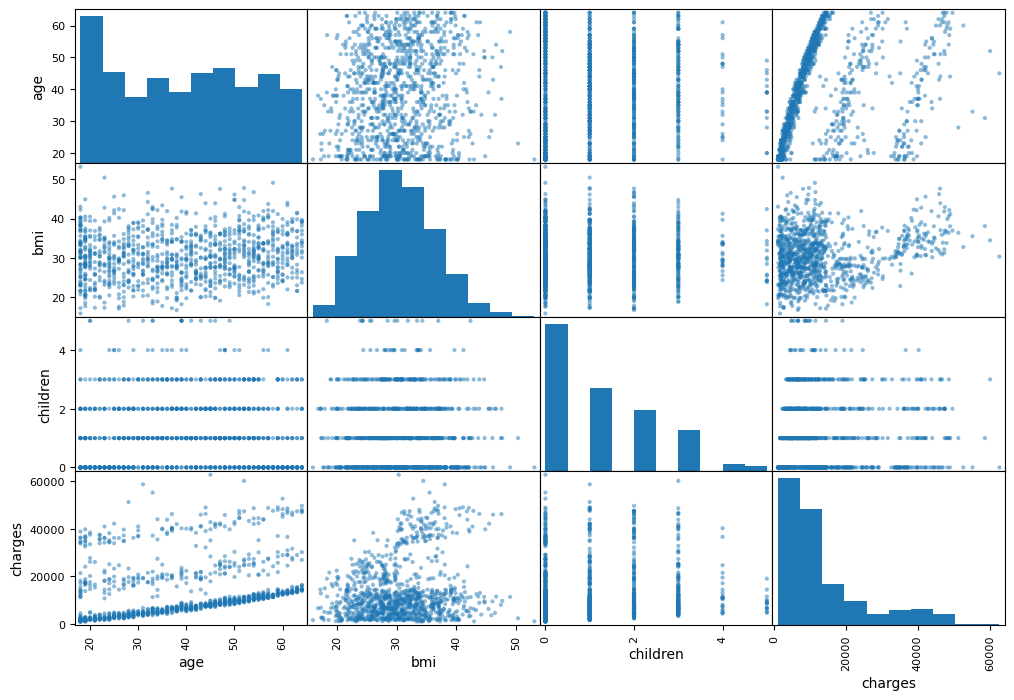

In [188]:
# Another way to check for correlation is to plot a scatter matrix. It plots every numerical attribute against every other numerical attribute.

scatter_matrix(train_set, figsize=(12, 8))
plt.show()

From above plots, we can see that age and charges seems to have some unique relationship as it has 3 linear lines. Let's try to plot a scatter plot between them.

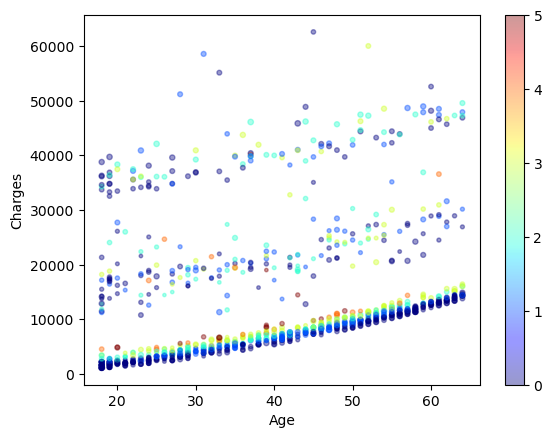

In [189]:
# Scatter plot between age and charges, with alpha=0.4 so that we can see the density and size of scatter points is set to bmi/3 to check if there is any relationship between bmi and charges and the color is set to children to check if there is any relationship between children and charges.

sc = plt.scatter(x=train_set["age"], y=train_set["charges"], alpha=0.4, s=train_set["bmi"] / 3, c=train_set["children"], cmap=plt.get_cmap("jet"))
plt.colorbar(sc)
plt.xlabel("Age")
plt.ylabel("Charges")
plt.show()

From above scatter plot we can see that children and bmi does not have any relation with charges. So let's try smoking feature

In [190]:
train_set_1 = train_set.copy()

In [191]:
train_set_1.replace({
    # Syntax explanation: In "smoker" column replace "yes" to 1 and "no" to 0
    "smoker": {
        "yes": 1,
        "no": 0
    }
}, inplace=True)
# train_set_1

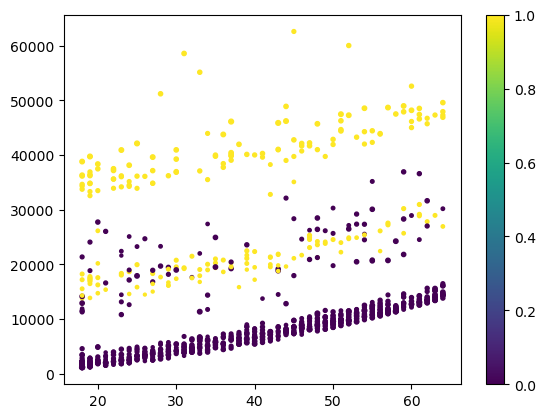

In [192]:
# Scatter plot between age and charges, with bmi as the size of the points and smoker/non-smoker as the color of the points

sc = plt.scatter(x=train_set_1["age"], y=train_set_1["charges"], s=train_set_1["bmi"] / 4, c=train_set_1["smoker"])
plt.colorbar(sc)
plt.show()

Indeed there is some relation with smoking. We can see that below 10,000 charges are all non smokers, whereas above 30,000 are all smokers.

Let's find out if there is relation with sex also.

In [193]:
train_set_1.replace({
    # Syntax explanation: In "smoker" column replace "yes" to 1 and "no" to 0
    "sex": {
        "female": 0,
        "male": 1
    }
}, inplace=True)
# train_set_1

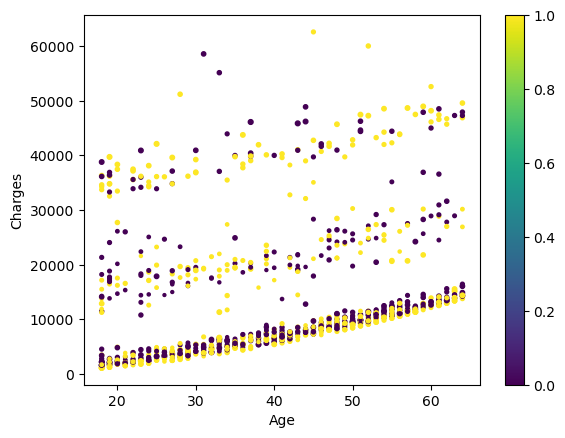

In [194]:
# Scatter plot between age and charges, with bmi as the size of the points and sex as the color of the points

sc = plt.scatter(x=train_set_1["age"], y=train_set_1["charges"], s=train_set_1["bmi"] / 4, c=train_set_1
["sex"])
plt.colorbar(sc)
plt.xlabel("Age")
plt.ylabel("Charges")
plt.show()

There is no special unique relation of sex with charges as all distribution is very random.

Let's check for the correlation among the features of the dataset.

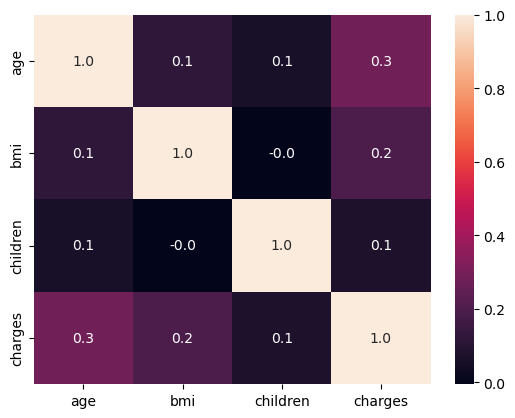

In [195]:
sns.heatmap(corr_mat, annot=True, fmt=".1f")
plt.show()

Our target variable is the "charges" column. So let's get the correlation of other columns with the "charges" column.

In [196]:
corr_mat["charges"].sort_values(ascending=False)

charges     1.000000
age         0.281721
bmi         0.197316
children    0.071885
Name: charges, dtype: float64

There is not much correlation between the features and the charges but yeah there is some correlation between the age and the charges.

# Attributes Combination

Let's try some attribute combinations to increase the number of features

In [197]:
train_set_2 = train_set.copy()
train_set_2

,age,sex,bmi,children,smoker,region,charges
560,46,female,19.950,2,no,northwest,9193.83850
1285,47,female,24.320,0,no,northeast,8534.67180
1142,52,female,24.860,0,no,southeast,27117.99378
969,39,female,34.320,5,no,southeast,8596.82780
486,54,female,21.470,3,no,northwest,12475.35130
...,...,...,...,...,...,...,...
1095,18,female,31.350,4,no,northeast,4561.18850
1130,39,female,23.870,5,no,southeast,8582.30230
1294,58,male,25.175,0,no,northeast,11931.12525
860,37,female,47.600,2,yes,southwest,46113.51100


First we will use "age" column to create a new column "age_group" with 5 categories: "0-18", "18-30", "30-45", "45-60", "60+"

In [198]:
age_bins = [0, 18, 30, 45, 60, 99]
age_labels = ["0-18", "18-30", "30-45", "45-60", "60+"]

train_set_2["age_group"] = pd.cut(train_set_2["age"], bins=age_bins, labels=age_labels, right=False)

Now let's use "bmi" column to create new columns "bmi_group" and we will divide bmi into 4 categories that is underweight, normal weight, overweight and obese

In [199]:
bmi_bins = [0, 18.5, 24.9, 29.9, float('inf')]
bmi_labels = ["underweight", "normal weight", "overweight", "obese"]

train_set_2["bmi_group"] = pd.cut(train_set_2["bmi"], bins=bmi_bins, labels=bmi_labels, right=False)

In [200]:
# Let's look at the dataset with two new features added
train_set_2

,age,sex,bmi,children,smoker,region,charges,age_group,bmi_group
560,46,female,19.950,2,no,northwest,9193.83850,45-60,normal weight
1285,47,female,24.320,0,no,northeast,8534.67180,45-60,normal weight
1142,52,female,24.860,0,no,southeast,27117.99378,45-60,normal weight
969,39,female,34.320,5,no,southeast,8596.82780,30-45,obese
486,54,female,21.470,3,no,northwest,12475.35130,45-60,normal weight
...,...,...,...,...,...,...,...,...,...
1095,18,female,31.350,4,no,northeast,4561.18850,18-30,obese
1130,39,female,23.870,5,no,southeast,8582.30230,30-45,normal weight
1294,58,male,25.175,0,no,northeast,11931.12525,45-60,overweight
860,37,female,47.600,2,yes,southwest,46113.51100,30-45,obese


We will now create a one more feature called "Charges_bmi_ratio" which is the ratio of "Charges" and "bmi" columns. This feature will help us to understand the relationship between "Charges" and "bmi" columns.

In [201]:
train_set_2["charges_bmi_ratio"] = np.round( train_set_2["charges"] / train_set_2["bmi"] )

Let's plot the charges_bmi_ratio column to see if there is any relationship between bmi and charges.

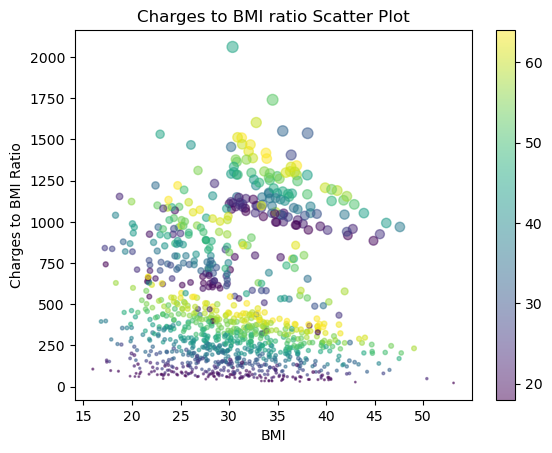

In [202]:
# Scatter plot of bmi vs charges_bmi_ratio, with size of the points determined by charges and color determined by age

sc = plt.scatter(x=train_set_2["bmi"], y=train_set_2["charges_bmi_ratio"], alpha=0.5, s=train_set_2["charges"] / 1000, c=train_set_2["age"])
plt.colorbar(sc)
plt.xlabel("BMI")
plt.ylabel("Charges to BMI Ratio")
plt.title("Charges to BMI ratio Scatter Plot")
plt.show()

From the plot we can see that, as charges_bmi_ratio increases, the charges also increases. Also, the charges are low for less charges_bmi_ratio and the people with age range of 0-30 years belong to that group.

As BMI increases, the charges also increases.

Let's try to calculate avg charges per region and plot it. 

In [203]:
# train_set_2.groupby('region').mean(numeric_only=True) # this group by according to values of regions and calculates mean for each of the numeric column in dataframe. We only want "charges"

avg_charges_per_region = train_set_2.groupby('region')["charges"].mean(numeric_only=True)

In [204]:
avg_charges_per_region

region
northeast    13333.008791
northwest    12622.514246
southeast    14698.242993
southwest    12611.500973
Name: charges, dtype: float64

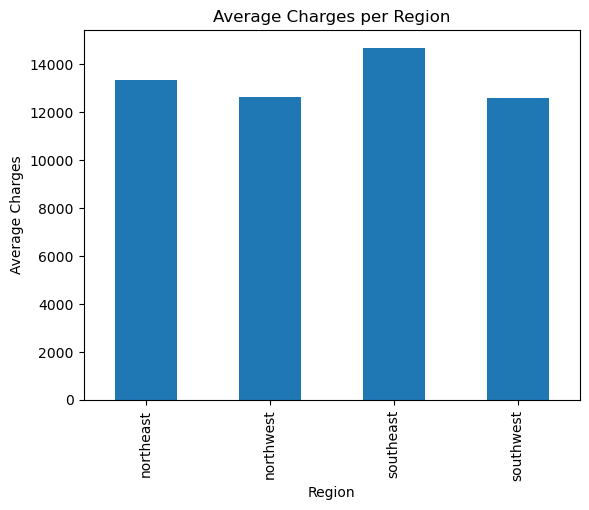

In [205]:
avg_charges_per_region.plot(kind="bar")
plt.xlabel("Region")
plt.ylabel("Average Charges")
plt.title("Average Charges per Region")
plt.show()

All regions have almost similar average charges.

Let's explore the charges based on age group and see if we can find out some good inferences.

In [206]:
avg_charges_per_age_group = train_set_2.groupby("age_group")["charges"].mean(numeric_only=True)

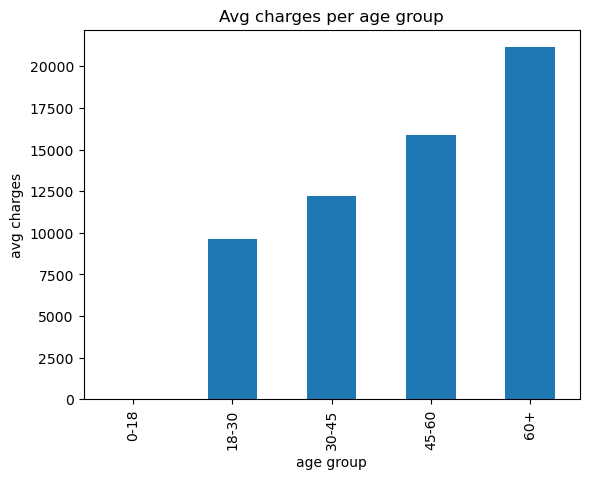

In [207]:
avg_charges_per_age_group.plot(kind="bar")
plt.xlabel("age group")
plt.ylabel("avg charges")
plt.title("Avg charges per age group")
plt.show()

"60+" age group has the highest average charges. This means that old people are more likely to have higher medical charges than young people.

But there maybe the case that in the dataset, there are more young people than old people. So the overall average charges of of young people maybe diluted by the large number of young people. REASON: More people means higher denominator, which means lower average.

Let's see average charges per bmi group

In [208]:
avg_charges_per_bmi_group = train_set_2.groupby("bmi_group")["charges"].mean(numeric_only=True)

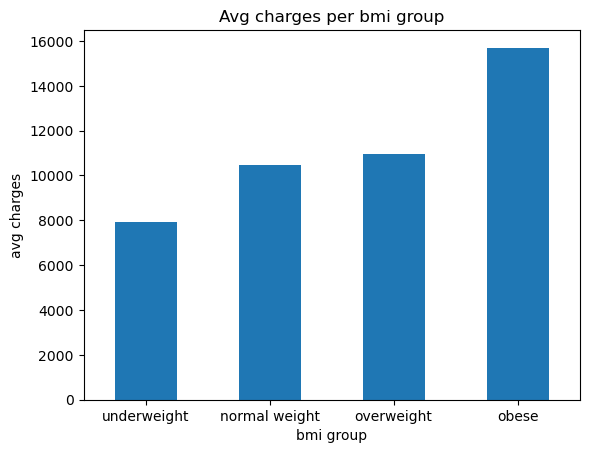

In [209]:
avg_charges_per_bmi_group.plot(kind="bar")
plt.xlabel("bmi group")
plt.xticks(rotation=0) # this for for x-axis labels
plt.ylabel("avg charges")
plt.title("Avg charges per bmi group")
plt.show()

We can see from the above plot that, "obese" people have higher average charges.

That's it for attribute combination, if needed will come back to this section. 

# Preparing Data for Model

Now let's prepare the data for ML model. 

We will do data cleaning (if needed),  encoding and will prepare transformation pipelines.

In [210]:
train_set_3 = train_set_2.copy()

In [211]:
train_set_3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1070 entries, 560 to 1126
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   age                1070 non-null   int64   
 1   sex                1070 non-null   object  
 2   bmi                1070 non-null   float64 
 3   children           1070 non-null   int64   
 4   smoker             1070 non-null   object  
 5   region             1070 non-null   object  
 6   charges            1070 non-null   float64 
 7   age_group          1070 non-null   category
 8   bmi_group          1070 non-null   category
 9   charges_bmi_ratio  1070 non-null   float64 
dtypes: category(2), float64(3), int64(2), object(3)
memory usage: 77.7+ KB


There are no empty values. That's great, but there are two columns with "category" data type, first we need to cast them to "object" data type.

In [212]:
train_set_3 = train_set_3.astype({
    "age_group": "object",
    "bmi_group": "object"
})

In [213]:
train_set_3.dtypes

age                    int64
sex                   object
bmi                  float64
children               int64
smoker                object
region                object
charges              float64
age_group             object
bmi_group             object
charges_bmi_ratio    float64
dtype: object

Now all columns are in their proper data types.

## Seperating target and features

In [214]:
train_set_4 = train_set_3.copy()

In [215]:
insurance_features = train_set_4.drop("charges", axis=1)
insurance_labels = train_set_4["charges"].copy()

In [216]:
insurance_features.head() 

,age,sex,bmi,children,smoker,region,age_group,bmi_group,charges_bmi_ratio
560,46,female,19.95,2,no,northwest,45-60,normal weight,461.0
1285,47,female,24.32,0,no,northeast,45-60,normal weight,351.0
1142,52,female,24.86,0,no,southeast,45-60,normal weight,1091.0
969,39,female,34.32,5,no,southeast,30-45,obese,250.0
486,54,female,21.47,3,no,northwest,45-60,normal weight,581.0


In [217]:
insurance_labels

560      9193.83850
1285     8534.67180
1142    27117.99378
969      8596.82780
486     12475.35130
           ...     
1095     4561.18850
1130     8582.30230
1294    11931.12525
860     46113.51100
1126    10214.63600
Name: charges, Length: 1070, dtype: float64

## Handling Categorical Data

Now let's handle the categorical variables. We will use OneHotEncoder to encode the categorical variables.

In [218]:
insurance_features_1 = insurance_features.copy()

In [219]:
insurance_features_1.select_dtypes("object")

,sex,smoker,region,age_group,bmi_group
560,female,no,northwest,45-60,normal weight
1285,female,no,northeast,45-60,normal weight
1142,female,no,southeast,45-60,normal weight
969,female,no,southeast,30-45,obese
486,female,no,northwest,45-60,normal weight
...,...,...,...,...,...
1095,female,no,northeast,18-30,obese
1130,female,no,southeast,30-45,normal weight
1294,male,no,northeast,45-60,overweight
860,female,yes,southwest,30-45,obese


In [220]:
cat_insurance_features = insurance_features_1.select_dtypes("object").columns
cat_insurance_features

Index(['sex', 'smoker', 'region', 'age_group', 'bmi_group'], dtype='object')

In [221]:
cat_features_encoder = OneHotEncoder(sparse_output=False)
one_hot_encoded_attr = cat_features_encoder.fit_transform(insurance_features_1[cat_insurance_features])

In [222]:
one_hot_encoded_attr

array([[1., 0., 1., ..., 0., 0., 0.],
       [1., 0., 1., ..., 0., 0., 0.],
       [1., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 1., 1., ..., 0., 1., 0.],
       [1., 0., 0., ..., 1., 0., 0.],
       [0., 1., 1., ..., 1., 0., 0.]])

In [223]:
cat_features_encoder.categories_

[array(['female', 'male'], dtype=object),
 array(['no', 'yes'], dtype=object),
 array(['northeast', 'northwest', 'southeast', 'southwest'], dtype=object),
 array(['18-30', '30-45', '45-60', '60+'], dtype=object),
 array(['normal weight', 'obese', 'overweight', 'underweight'],
       dtype=object)]

In [224]:
cat_features_encoder.get_feature_names_out(cat_insurance_features) # gives the feature names for the one hot encoded features

array(['sex_female', 'sex_male', 'smoker_no', 'smoker_yes',
       'region_northeast', 'region_northwest', 'region_southeast',
       'region_southwest', 'age_group_18-30', 'age_group_30-45',
       'age_group_45-60', 'age_group_60+', 'bmi_group_normal weight',
       'bmi_group_obese', 'bmi_group_overweight', 'bmi_group_underweight'],
      dtype=object)

In [225]:
# Now we have both encoded data and column names. So we can easily create a dataframe from it

one_hot_encoded_attr_df = pd.DataFrame(one_hot_encoded_attr, columns=cat_features_encoder.get_feature_names_out(cat_insurance_features), index=insurance_features_1.index)

one_hot_encoded_attr_df

,sex_female,sex_male,smoker_no,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest,age_group_18-30,age_group_30-45,age_group_45-60,age_group_60+,bmi_group_normal weight,bmi_group_obese,bmi_group_overweight,bmi_group_underweight
560,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
1285,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
1142,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
969,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
486,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1095,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1130,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
1294,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
860,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


Currenly we added new combined attributes, such as age_group, bmi_group and charges_bmi_ratio manually. But suppose if new data comes, we will not have these attributes. 

So we need to create a pipeline to do all the transformations automatically. We will make one class for adding the new attributes to the dataset. For this class we will use sklearn BaseEstimator and TransformerMixin classes. They provide fit_transform() method for free.

In [226]:
from sklearn.base import BaseEstimator, TransformerMixin

age_bins = [0, 18, 30, 45, 60, 99]
age_labels = ["0-18", "18-30", "30-45", "45-60", "60+"]

bmi_bins = [0, 18.5, 24.9, 29.9, float('inf')]
bmi_labels = ["underweight", "normal weight", "overweight", "obese"]

class CustomAttrAdder(BaseEstimator, TransformerMixin):
    def __init__(self) -> None:
        return None

    def fit(self, X, y=None):
        return self
    
    def transform(self, X) -> pd.DataFrame:
        X_copy = X.copy()
        X_copy["age_group"] = pd.cut(X["age"], bins=age_bins, labels=age_labels, right=False)

        X_copy["bmi_group"] = pd.cut(X["bmi"], bins=bmi_bins, labels=bmi_labels, right=False)

        cat_cols = X_copy.select_dtypes(include=["object", "category"]).columns
        
        # return only categorical columns
        return X_copy[cat_cols]


Let's test the above function

In [227]:
train_set_6 = train_set.copy()

In [228]:
attr_adder = CustomAttrAdder()
train_set_extra_attr = attr_adder.transform(train_set_6)

In [229]:
train_set_extra_attr.head()

,sex,smoker,region,age_group,bmi_group
560,female,no,northwest,45-60,normal weight
1285,female,no,northeast,45-60,normal weight
1142,female,no,southeast,45-60,normal weight
969,female,no,southeast,30-45,obese
486,female,no,northwest,45-60,normal weight


Working perfectly!! We passed the dataframe and it returned the dataframe with the new column added. 

NOTE: We will only get categorical columns in the new dataframe because we are returning only that columns from our custom function.

## Feature Scaling

It's time for some feature scaling. We will use Scikit-Learn's  StandardScaler for that.

In [230]:
insurance_features = train_set.drop("charges", axis=1)
insurance_features.head()

,age,sex,bmi,children,smoker,region
560,46,female,19.95,2,no,northwest
1285,47,female,24.32,0,no,northeast
1142,52,female,24.86,0,no,southeast
969,39,female,34.32,5,no,southeast
486,54,female,21.47,3,no,northwest


Standard Scaler works only on numerical valus. So, we need to get select only numerical values from the dataset.

In [231]:
insurance_features_num = insurance_features.select_dtypes(np.number)
insurance_features_num.head()

,age,bmi,children
560,46,19.95,2
1285,47,24.32,0
1142,52,24.86,0
969,39,34.32,5
486,54,21.47,3


In [232]:
num_pipeline = Pipeline([
    ("std_scaler", StandardScaler())
])

Let's test our pipeline

In [233]:
insurance_features_num_tr = num_pipeline.fit_transform(insurance_features_num)

In [234]:
insurance_features_num_tr

array([[ 0.47222651, -1.75652513,  0.73433626],
       [ 0.54331294, -1.03308239, -0.91119211],
       [ 0.8987451 , -0.94368672, -0.91119211],
       ...,
       [ 1.3252637 , -0.89153925, -0.91119211],
       [-0.16755139,  2.82086429,  0.73433626],
       [ 1.1120044 , -0.10932713, -0.91119211]])

It is working perfectly fine. We can see that numerical features have been scaled

In [235]:
# Converting scaled features back to a dataframe

insurance_features_num = pd.DataFrame(insurance_features_num_tr, columns=insurance_features_num.columns)
insurance_features_num.head()

,age,bmi,children
0,0.472227,-1.756525,0.734336
1,0.543313,-1.033082,-0.911192
2,0.898745,-0.943687,-0.911192
3,-0.025379,0.622393,3.202629
4,1.040918,-1.504893,1.557100


Now let's create a categorical pipeline for handling categorical variables.

In [236]:
insurance_features_cat = insurance_features.select_dtypes(include=['object'])
insurance_features_cat.head()

,sex,smoker,region
560,female,no,northwest
1285,female,no,northeast
1142,female,no,southeast
969,female,no,southeast
486,female,no,northwest


For categorical attributes, we will first add the custom attributes and then will encode it using OneHotEncoder

In [237]:
cat_pipline = Pipeline([
    ("attribs_adder",  CustomAttrAdder()),
    ("encoder",  OneHotEncoder(sparse_output=False))
])

In [238]:
insurance_features_cat_tr = cat_pipline.fit_transform(insurance_features)
insurance_features_cat_tr

array([[1., 0., 1., ..., 0., 0., 0.],
       [1., 0., 1., ..., 0., 0., 0.],
       [1., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 1., 1., ..., 0., 1., 0.],
       [1., 0., 0., ..., 1., 0., 0.],
       [0., 1., 1., ..., 1., 0., 0.]])

In [239]:
cat_pipline.named_steps # This lists all the steps in the pipeline

{'attribs_adder': CustomAttrAdder(),
 'encoder': OneHotEncoder(sparse_output=False)}

In [240]:
cat_pipline.named_steps["encoder"].get_feature_names_out() # This outputs the names of the columns of the encoded data

array(['sex_female', 'sex_male', 'smoker_no', 'smoker_yes',
       'region_northeast', 'region_northwest', 'region_southeast',
       'region_southwest', 'age_group_18-30', 'age_group_30-45',
       'age_group_45-60', 'age_group_60+', 'bmi_group_normal weight',
       'bmi_group_obese', 'bmi_group_overweight', 'bmi_group_underweight'],
      dtype=object)

In [241]:
# storing the column names of the encoded columns so that we can convert the encoded array back to a dataframe
encoder_out_cols = cat_pipline.named_steps["encoder"].get_feature_names_out() 

In [242]:
insurance_features_cat = pd.DataFrame(insurance_features_cat_tr, columns=encoder_out_cols)
insurance_features_cat.head()

,sex_female,sex_male,smoker_no,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest,age_group_18-30,age_group_30-45,age_group_45-60,age_group_60+,bmi_group_normal weight,bmi_group_obese,bmi_group_overweight,bmi_group_underweight
0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
1,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
2,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
3,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
4,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0


Let's integrate both pipelines into one. For this we need a class name DataFrameSelector that will select the desired attributes (numerical or categorical), drop the rest and convert the resulting DataFrame to a NumPy array. 

In [243]:
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        return X[self.attribute_names]

In [244]:
num_attr = insurance_features.select_dtypes(np.number).columns
cat_attr = insurance_features.select_dtypes(include=["object"]).columns

In [245]:
num_pipeline = Pipeline([
    ('selector', DataFrameSelector(num_attr)),
    ("scaler", StandardScaler())
])

cat_pipeline = Pipeline([
    ('selector', DataFrameSelector(list(cat_attr) + ["age", "bmi"])),
    ("attribs_adder",  CustomAttrAdder()),
    ("encoder",  OneHotEncoder(sparse_output=False))
])

full_pipeline = FeatureUnion(transformer_list=[
    ("num_pipeline", num_pipeline),
    ("cat_pipeline", cat_pipeline)
])

In [246]:
insurance_prepared = full_pipeline.fit_transform(insurance_features)

In [247]:
insurance_prepared

array([[ 0.47222651, -1.75652513,  0.73433626, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.54331294, -1.03308239, -0.91119211, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.8987451 , -0.94368672, -0.91119211, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 1.3252637 , -0.89153925, -0.91119211, ...,  0.        ,
         1.        ,  0.        ],
       [-0.16755139,  2.82086429,  0.73433626, ...,  1.        ,
         0.        ,  0.        ],
       [ 1.1120044 , -0.10932713, -0.91119211, ...,  1.        ,
         0.        ,  0.        ]])

Our data is now prepared for the model. We scaled the data, added new features and encoded the categorical features. We are now ready to build the model.

# Model Training

### Linear Regression

Let's train the model, starting with simple linear regression.

In [248]:
lin_reg = LinearRegression()
lin_reg.fit(insurance_prepared, insurance_labels)

LinearRegression()

Our model is trained. Let's try it on some instances of the training set

In [249]:
some_data = insurance_features.iloc[:5]
some_labels = insurance_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)

print("Predictions:\t", list(lin_reg.predict(some_data_prepared)))

Predictions:	 [7719.484084624184, 7808.148536626326, 8573.982097190792, 11403.521890397094, 10438.710888331148]


We got the predictions from our model. Let's match them with original values.

In [250]:
print("Labels: \t", list(some_labels))

Labels: 	 [9193.8385, 8534.6718, 27117.99378, 8596.8278, 12475.3513]


We can see that predictions are not that accurate. Let's measure the RMSE of the model on the whole training set using Scikit-Learn's `mean_squared_error()` function:

In [251]:
insurance_predictions = lin_reg.predict(insurance_prepared)
lin_mse = mean_squared_error(insurance_labels, insurance_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

5999.478997723757

Ofcourse it's not a great score but it is good than nothing 😅 . Charges are ranging from 1121 to 63770, so typical prediction error of approx 60000 is not great. 

Let's see if we can do better with other models.

### Ridge Regression

In [254]:
ridge = Ridge(random_state=42)
ridge.fit(insurance_prepared, insurance_labels)

Ridge(random_state=42)

Let's calculate RMSE of ridge regression on whole training set.

In [255]:
insurance_predictions = ridge.predict(insurance_prepared)
ridge_mse = mean_squared_error(insurance_labels, insurance_predictions)
ridge_rmse = np.sqrt(ridge_mse)
ridge_rmse

5999.6084652396385

Ridge Regression and Simple Linear Regression are performing almost similar. We can tune Rigde Regression to get better results, but first we will try all models and then tune the best model.

### Lasso Regression

In [257]:
lasso = Lasso(random_state=42)
lasso.fit(insurance_prepared, insurance_labels)

Lasso(random_state=42)

Calculating RMSE

In [258]:
insurance_predictions = lasso.predict(insurance_prepared)
lasso_mse = mean_squared_error(insurance_labels, insurance_predictions)
lasso_rmse = np.sqrt(lasso_mse)
lasso_rmse

5999.495823478217

Slightly better than the previous one, but still not good enough.

### Elastic Net

In [260]:
elastic_net = ElasticNet(random_state=42)
elastic_net.fit(insurance_prepared, insurance_labels)

ElasticNet(random_state=42)

In [261]:
# calculate rmse

insurance_predictions = elastic_net.predict(insurance_prepared)
elastic_net_mse = mean_squared_error(insurance_labels, insurance_predictions)
elastic_net_rmse = np.sqrt(elastic_net_mse)
elastic_net_rmse

8451.408659206018

Elastic net is not performing well. Infact it is performing worst than all three models (Simple Linear Regression, Ridge and Lasso).

It's time to try some more complex models. For eg: SVMs, Decision Trees, Random Forests, etc.

### Linear SVR

In [263]:
lin_svr = LinearSVR(random_state=42)
lin_svr.fit(insurance_prepared, insurance_labels)

LinearSVR(random_state=42)

In [264]:
# calculate rmse

insurance_predictions = lin_svr.predict(insurance_prepared)
lin_svr_mse = mean_squared_error(insurance_labels, insurance_predictions)
lin_svr_rmse = np.sqrt(lin_svr_mse)
lin_svr_rmse

16074.38156325731

It is performing even worst 🙂

### Support Vector Regression

In [266]:

svr = SVR()
svr.fit(insurance_prepared, insurance_labels)

SVR()

In [267]:
# calculate rmse

insurance_predictions = svr.predict(insurance_prepared)
svr_mse = mean_squared_error(insurance_labels, insurance_predictions)
svr_rmse = np.sqrt(svr_mse)
svr_rmse

12580.371267737179

Better than linear SVR!!

### Decision Tree

In [269]:
tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(insurance_prepared, insurance_labels)

DecisionTreeRegressor(random_state=42)

In [270]:
# calculate rmse
from sklearn.metrics import mean_squared_error

insurance_predictions = tree_reg.predict(insurance_prepared)
tree_reg_mse = mean_squared_error(insurance_labels, insurance_predictions)
tree_reg_rmse = np.sqrt(tree_reg_mse)
tree_reg_rmse

494.20598375812835

Wooahh!! 😶 Best results so far. But hold on, the model maybe overfitting. We will use cross validation later on to check that.

### Random Forest Regressor

In [272]:
forest_reg = RandomForestRegressor(random_state=42)
forest_reg.fit(insurance_prepared, insurance_labels)

RandomForestRegressor(random_state=42)

In [273]:
# calculate rmse

insurance_predictions = forest_reg.predict(insurance_prepared)
forest_reg_mse = mean_squared_error(insurance_labels, insurance_predictions)
forest_reg_rmse = np.sqrt(forest_reg_mse)
forest_reg_rmse

1905.7875731496606

Not better than Decision Tree but much better than all other models.

# Evaluating Model

In [277]:
# function to display scores of cross validation in a better way

def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

Now let's evaluate the models using cross validation to check for.

### Evaluating Decision Tree Regressor

Starting with Decision tree regressor because it was outperforming the other models in the previous step.

In [275]:
scores = cross_val_score(tree_reg, insurance_prepared, insurance_labels, scoring="neg_mean_squared_error", cv=10)

tree_rmse_scores = np.sqrt(-scores)

In [276]:
tree_rmse_scores

array([5974.18511704, 6649.86619889, 6132.96093052, 6865.2813918 ,
       6960.57219291, 7245.27143205, 7197.73747093, 7366.96221554,
       7150.08300975, 5520.31892948])

In [278]:
display_scores(tree_rmse_scores)

Scores: [5974.18511704 6649.86619889 6132.96093052 6865.2813918  6960.57219291
 7245.27143205 7197.73747093 7366.96221554 7150.08300975 5520.31892948]
Mean: 6706.323888891187
Standard deviation: 594.1207036032815


Decision Tree got approx 6700 rmse on cross validation which is quite high. This means that the model is overfitting on the training set.

Let's evalulate other models also. We will hypertune the model which gives the best result on cross validation.

### Evaluating Linear Regression

In [279]:
scores = cross_val_score(lin_reg, insurance_prepared, insurance_labels, scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-scores)
display_scores(lin_rmse_scores)

Scores: [6093.5748506  6542.0872246  5117.35043508 5778.48600634 5815.04766175
 5961.7631347  7169.31666773 6236.30316078 6241.51943046 5719.9499722 ]
Mean: 6067.5398544227355
Standard deviation: 517.7554372574031


Linear Regression giving little bit good result as compared to decision tree

### Evaluating Ridge Regression

In [280]:
scores = cross_val_score(ridge, insurance_prepared, insurance_labels, scoring="neg_mean_squared_error", cv=10)
ridge_rmse_scores = np.sqrt(-scores)
display_scores(ridge_rmse_scores)

Scores: [6091.49488217 6545.48624939 5116.06962016 5782.49718202 5814.68655387
 5957.68162818 7161.7476748  6229.46425272 6241.63077205 5722.29752743]
Mean: 6066.305634279667
Standard deviation: 516.1928028322361


### Evaluating Lasso Regression

In [281]:
scores = cross_val_score(lasso, insurance_prepared, insurance_labels, scoring="neg_mean_squared_error", cv=10)
lasso_rmse_scores = np.sqrt(-scores)
display_scores(lasso_rmse_scores)

Scores: [6092.45353599 6542.17682801 5115.28687429 5780.00472383 5811.90972448
 5959.54305101 7167.8217675  6233.43864528 6240.48987157 5719.85853303]
Mean: 6066.298355497574
Standard deviation: 517.8121767730106


### Evaluating ElasticNet Regression

In [282]:
scores = cross_val_score(elastic_net, insurance_prepared, insurance_labels, scoring="neg_mean_squared_error", cv=10)
elastic_net_rmse_scores = np.sqrt(-scores)
display_scores(elastic_net_rmse_scores)

Scores: [8398.31447213 8705.42546905 8209.51840414 9266.72704231 8778.82176857
 7262.3892073  8608.49452383 8340.99468005 8827.66463068 8375.17254379]
Mean: 8477.352274185347
Standard deviation: 498.9070154187217


### Evaluating Linear SVR

In [283]:
scores = cross_val_score(lin_svr, insurance_prepared, insurance_labels, scoring="neg_mean_squared_error", cv=10)
lin_svr_rmse_scores = np.sqrt(-scores)
display_scores(lin_svr_rmse_scores)

Scores: [16348.25578479 16086.43297391 16363.53632422 18718.40804826
 16344.87880411 14186.58990607 16180.29337418 15750.24309794
 16364.10074226 15468.80109433]
Mean: 16181.154015006896
Standard deviation: 1060.1655225503907


### Evaluating SVR

In [284]:
scores = cross_val_score(svr, insurance_prepared, insurance_labels, scoring="neg_mean_squared_error", cv=10)
svr_rmse_scores = np.sqrt(-scores)
display_scores(svr_rmse_scores)

Scores: [12536.77057571 12485.19768831 12832.32506913 14514.80103741
 13013.52465725 10429.72286687 12329.66739219 12164.93716691
 12948.59560486 12267.36681114]
Mean: 12552.290886979066
Standard deviation: 953.4402175915912


### Evaluating Random Forest Regression

In [285]:
scores = cross_val_score(forest_reg, insurance_prepared, insurance_labels, scoring="neg_mean_squared_error", cv=10)
forest_reg_rmse_scores = np.sqrt(-scores)
display_scores(forest_reg_rmse_scores)

Scores: [4850.17562421 5306.53331811 3810.10535541 4470.31291162 5311.76230223
 4969.2479273  5648.41385395 5412.58176671 5151.13817405 4681.37668347]
Mean: 4961.16479170525
Standard deviation: 510.9711528302854


# RMSE Scores

Let's compare the RMSE scores of all model on cross validation set:

In [286]:
cross_val_scores = {
    "tree_reg": tree_rmse_scores.mean(),
    "lin_reg": lin_rmse_scores.mean(),
    "ridge_reg": ridge_rmse_scores.mean(),
    "lasso_reg": lasso_rmse_scores.mean(),
    "elastic_net_reg": elastic_net_rmse_scores.mean(),
    "lin_svr_reg": lin_svr_rmse_scores.mean(),
    "svr_reg": svr_rmse_scores.mean(),
    "forest_reg": forest_reg_rmse_scores.mean(),
}

cross_val_scores

{'tree_reg': 6706.323888891187,
 'lin_reg': 6067.5398544227355,
 'ridge_reg': 6066.305634279667,
 'lasso_reg': 6066.298355497574,
 'elastic_net_reg': 8477.352274185347,
 'lin_svr_reg': 16181.154015006896,
 'svr_reg': 12552.290886979066,
 'forest_reg': 4961.16479170525}

In [287]:
# sorting scores based on the rmse value
sorted_cross_val_score = dict(sorted(cross_val_scores.items(), key=lambda x: x[1]))
sorted_cross_val_score

{'forest_reg': 4961.16479170525,
 'lasso_reg': 6066.298355497574,
 'ridge_reg': 6066.305634279667,
 'lin_reg': 6067.5398544227355,
 'tree_reg': 6706.323888891187,
 'elastic_net_reg': 8477.352274185347,
 'svr_reg': 12552.290886979066,
 'lin_svr_reg': 16181.154015006896}

In [288]:
# get model which has minimum score

key = min(cross_val_scores, key=lambda x: cross_val_scores[x])
key, cross_val_scores[key]

('forest_reg', 4961.16479170525)

Alright, Random Forest it is!

Random Forest got least RMSE score on the cross validation set. It's time to hyperparameter tune it.

# Hyperparameter Tuning

We will use grid search cv to fine tune the hyperparameters.

In [290]:
forest_param_grid = [
    { "n_estimators": [10, 20, 30, 40, 50], "max_depth": [3, 5, 7, 9, 11] }, 
    { "bootstrap": [False], "n_estimators": [3, 10], "max_depth": [3, 5, 7, 9, 11]}
]

In [291]:
forest_reg = RandomForestRegressor()

forest_grid_search = GridSearchCV(forest_reg, forest_param_grid, cv=5, scoring='neg_mean_squared_error', refit=True)
forest_grid_search.fit(insurance_prepared, insurance_labels)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid=[{'max_depth': [3, 5, 7, 9, 11],
                          'n_estimators': [10, 20, 30, 40, 50]},
                         {'bootstrap': [False], 'max_depth': [3, 5, 7, 9, 11],
                          'n_estimators': [3, 10]}],
             scoring='neg_mean_squared_error')

In [292]:
forest_grid_search.best_params_

{'max_depth': 5, 'n_estimators': 20}

In [293]:
np.sqrt(-forest_grid_search.best_score_)

4678.130786847149

Score has improved a bit.

In [296]:
forest_reg_fine_tuned_score = np.sqrt(-forest_grid_search.best_score_)
forest_reg_fine_tuned_score

4678.130786847149

So we got our final model, random forest is it. Let's test it on the test set.

# Evaluating on test data

In [297]:
final_model = forest_grid_search.best_estimator_
final_model

RandomForestRegressor(max_depth=5, n_estimators=20)

In [298]:
X_test = test_set.drop("charges", axis=1)
y_test = test_set["charges"].copy()

In [299]:
X_test_prepared = full_pipeline.transform(X_test)
# X_test_prepared

In [300]:
final_predictions = final_model.predict(X_test_prepared)

In [301]:
final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

In [302]:
final_rmse

4427.980456339835

In [305]:
r2score = r2_score(y_test, final_predictions)

In [306]:
r2score

0.8737058220487521

We got R2_score of 0.87 which is quite good.

# Conclusion

Thank you for taking the time to explore my first Kaggle Notebook. I hope you found it insightful and interesting. 

Your suggestions and feedback are incredibly valuable to me. Constructive criticism is always welcome, as it helps me refine my skills. 